<a href="https://colab.research.google.com/github/ajinkya252005/Anomaly-Detection-PdM/blob/main/Anamoly_Detection_PdM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predictive Maintenance: Anomaly Detection

This notebook implements an Anomaly Detection model for predictive maintenance, aligning with the "Predictive Maintenance: Analysis and Future Outlook" framework.

Since failure labels are often scarce in real-world scenarios, this approach utilizes an **Autoencoder**. The model will be trained on data representing normal operational behavior. During inference, if the model encounters anomalous behavior (e.g., equipment degrading or acting abnormally), it will yield a high reconstruction error, flagging it as an anomaly.

## Step 1: Environment Setup & Data Loading
First, we import the necessary libraries and load our training and testing datasets from the provided `.parquet` files.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style for better visuals
plt.style.use('ggplot')

# Load the datasets
# Google Colab comes with pyarrow/fastparquet pre-installed to handle .parquet files
try:
    train_df = pd.read_parquet('train.parquet')
    test_df = pd.read_parquet('test.parquet')
    print("✅ Datasets loaded successfully!\n")

    # Display basic information about the training data
    print("--- Training Data Shape ---")
    print(train_df.shape, "\n")

    print("--- Training Data Columns and Types ---")
    print(train_df.info(), "\n")

    print("--- First 5 rows of Training Data ---")
    display(train_df.head())

except FileNotFoundError:
    print("❌ Error: Parquet files not found. Please ensure 'train.parquet' and 'test.parquet' are uploaded to the Colab files section.")

✅ Datasets loaded successfully!

--- Training Data Shape ---
(1639424, 7) 

--- Training Data Columns and Types ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1639424 entries, 0 to 1639423
Data columns (total 7 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   Date    1639424 non-null  datetime64[ns]
 1   X1      1639424 non-null  float64       
 2   X2      1639424 non-null  float64       
 3   X3      1639424 non-null  float64       
 4   X4      1639424 non-null  float64       
 5   X5      1639424 non-null  float64       
 6   target  1639424 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 87.6+ MB
None 

--- First 5 rows of Training Data ---


,Date,X1,X2,X3,X4,X5,target
0,2020-12-16,1.518921,5.463154,1.0,2.718282,2.890372,0
1,2020-12-16,1.546509,5.458010,1.0,2.718282,2.833213,1
2,2020-12-16,1.645427,5.456560,1.0,7.389056,2.890372,1
3,2020-12-16,1.652022,5.458479,1.0,2.718282,2.890372,1
4,2020-12-16,1.695538,5.466709,1.0,2.718282,2.890372,0


## Step 2: Data Preprocessing & Scaling

Before feeding data into the Autoencoder, we need to prepare it:
1. **Time Indexing:** We will set the `Date` column as the index so we can keep track of when events happen.
2. **Feature Scaling:** Neural networks perform best when input features are scaled. We will use `StandardScaler` to scale our sensor readings (`X1` to `X5`) so they have a mean of 0 and a standard deviation of 1.
3. **Target Inspection:** We need to see what labels exist in our `target` column so we can isolate the "Normal" data for training the Autoencoder.

In [2]:
from sklearn.preprocessing import StandardScaler

# 1. Set Date as the index for both train and test
train_df.set_index('Date', inplace=True)
test_df.set_index('Date', inplace=True)

# 2. Check the unique values in the 'target' column to see what our labels are
print("--- Target Class Distribution in Training Data ---")
print(train_df['target'].value_counts(dropna=False))
print("\n")

# 3. Define the features we want to scale (X1 to X5)
sensor_cols = ['X1', 'X2', 'X3', 'X4', 'X5']

# Initialize the scaler
scaler = StandardScaler()

# 4. Scale the training and testing data
# We only fit the scaler on the training data to prevent data leakage!
train_scaled = pd.DataFrame(scaler.fit_transform(train_df[sensor_cols]),
                            columns=sensor_cols,
                            index=train_df.index)

test_scaled = pd.DataFrame(scaler.transform(test_df[sensor_cols]),
                           columns=sensor_cols,
                           index=test_df.index)

# Add the target column back to the scaled training data for filtering later
train_scaled['target'] = train_df['target']

print("✅ Data scaled successfully!")
print("--- First 3 rows of Scaled Training Data ---")
display(train_scaled.head(3))

--- Target Class Distribution in Training Data ---
target
0    1625386
1      14038
Name: count, dtype: int64


✅ Data scaled successfully!
--- First 3 rows of Scaled Training Data ---


,X1,X2,X3,X4,X5,target
Date,,,,,,
2020-12-16,2.727476,-1.864371,-0.001752,-0.004656,1.305284,0
2020-12-16,2.925668,-2.247433,-0.001752,-0.004656,1.261479,1
2020-12-16,3.636292,-2.355426,-0.001752,-0.004656,1.305284,1


## Step 3: Filtering Data & Building the Autoencoder

Now that our data is scaled, we will:
1. **Filter the Training Data:** We isolate only the "Normal" instances (where target is `0`) to train our model. The Autoencoder must only learn healthy behavior.
2. **Define the Architecture:** We will build a Deep Autoencoder using TensorFlow/Keras. It consists of:
   - An **Encoder** that compresses the 5 sensor readings down to a smaller "bottleneck" representation.
   - A **Decoder** that tries to reconstruct the original 5 readings from the bottleneck.
3. **Compile:** We use Mean Squared Error (MSE) to measure how well the model reconstructs the input.

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# 1. Isolate the NORMAL training data (Target == 0)
# We convert the target to string to be safe, since pandas read it as an 'object' initially
normal_train_data = train_scaled[train_scaled['target'].astype(str) == '0'].drop(columns=['target'])

# Convert to numpy array for TensorFlow
X_train_normal = normal_train_data.values

print(f"✅ Filtered Normal Training Data Shape: {X_train_normal.shape}")

# 2. Define the Autoencoder Architecture
input_dim = X_train_normal.shape[1] # This will be 5 (for X1 to X5)

# Input layer
input_layer = Input(shape=(input_dim,), name="Input_Layer")

# Encoder part (compresses the data)
encoder = Dense(16, activation="relu", name="Encoder_1")(input_layer)
encoder = Dense(8, activation="relu", name="Encoder_2")(encoder)
encoder = Dense(4, activation="relu", name="Bottleneck")(encoder) # Bottleneck layer

# Decoder part (reconstructs the data)
decoder = Dense(8, activation="relu", name="Decoder_1")(encoder)
decoder = Dense(16, activation="relu", name="Decoder_2")(decoder)
output_layer = Dense(input_dim, activation="linear", name="Output_Layer")(decoder)

# 3. Create and compile the model
autoencoder = Model(inputs=input_layer, outputs=output_layer, name="Anomaly_Detection_Autoencoder")
autoencoder.compile(optimizer='adam', loss='mse')

print("\n--- Autoencoder Model Summary ---")
autoencoder.summary()

✅ Filtered Normal Training Data Shape: (1625386, 5)

--- Autoencoder Model Summary ---


Model: "Anomaly_Detection_Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)        │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_1 (Dense)               │ (None, 16)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_2 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Bottleneck (Dense)              │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder_1 (Dense)               │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder_2 (Dense)               │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 537 (2.10 KB)

 Trainable params: 537 (2.10 KB)

 Non-trainable params: 0 (0.00 B)

## Step 4: Training the Autoencoder

We will now train the model using only the **Normal** data.
- **Input & Output:** In an autoencoder, the input and the target output are exactly the same (`X_train_normal`).
- **Validation Split:** We reserve 10% of the normal data to validate the model during training and ensure it isn't overfitting.
- **Early Stopping:** We use a callback to stop training automatically if the validation loss stops improving, which saves time and prevents overfitting.

Starting training...
Epoch 1/50
5715/5715 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.0609 - val_loss: 0.0016
Epoch 2/50
5715/5715 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 8.8192e-04 - val_loss: 0.0016
Epoch 3/50
5715/5715 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 8.2841e-04 - val_loss: 0.0016
Epoch 4/50
5715/5715 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 5.3982e-04 - val_loss: 0.0015
Epoch 5/50
5715/5715 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 3.8686e-04 - val_loss: 8.6690e-05
Epoch 6/50
5715/5715 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 3.6611e-05 - val_loss: 5.1964e-06
Epoch 7/50
5715/5715 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 9.2477e-05 - val_loss: 1.1568e-05
Epoch 8/50
5715/5715 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 4.4065e-05 - val_loss: 2.6204e-04
Epoch 9/50
5715/5715 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 6.4579e-05 - val_loss: 6.8527e-06
Epoch 10/50
5715/5715 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 2.8942e-05 - val_loss: 4.2019e-06
Epoch 11/50
5715/5715 ━━━━━━

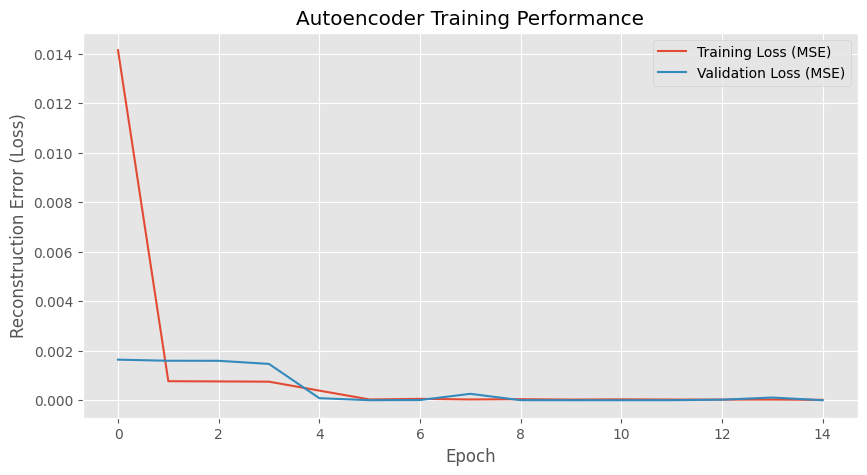

In [4]:
from tensorflow.keras.callbacks import EarlyStopping

# 1. Define Early Stopping
# This stops training if 'val_loss' doesn't improve for 5 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 2. Train the Model
print("Starting training...")
history = autoencoder.fit(
    X_train_normal, X_train_normal, # Input and Output are the same!
    epochs=50,                      # Maximum number of passes through the data
    batch_size=256,                 # Number of samples per gradient update
    validation_split=0.1,           # Use 10% of the data for validation
    callbacks=[early_stopping],     # Pass the early stopping rule
    verbose=1                       # Show progress bar (set to 0 to hide)
)
print("✅ Training complete!")

# 3. Plot the Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.title('Autoencoder Training Performance')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Error (Loss)')
plt.legend()
plt.show()

## Step 5: Detecting Anomalies in Test Data

To detect anomalies, we need to define what a "high" error is.
1. **Set Threshold:** We will calculate the reconstruction error on our normal training data and set the threshold at the 99th percentile. This means we allow a tiny bit of noise, but anything significantly worse than what the model saw in training will be flagged.
2. **Predict on Test Data:** We pass the unseen test data through the Autoencoder.
3. **Flag Anomalies:** Any test instance with a reconstruction error higher than our threshold is marked as an Anomaly (`True`).
4. **Visualize:** We will plot the reconstruction errors over time and highlight the anomalies in red.

50794/50794 ━━━━━━━━━━━━━━━━━━━━ 66s 1ms/step
🚨 Anomaly Threshold set to: 0.0000

12808/12808 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step
--- Test Data Anomaly Detection Summary ---
Anomaly
False    405224
True       4632
Name: count, dtype: int64




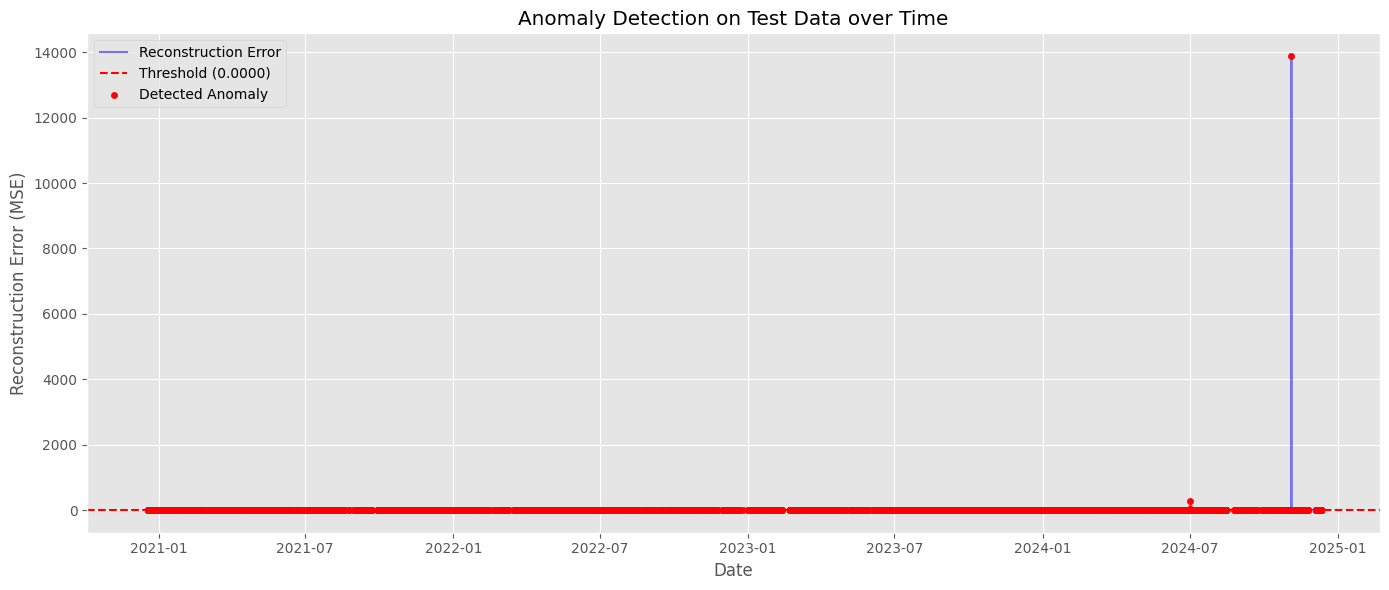

In [5]:
# 1. Calculate reconstruction error on normal training data to set a threshold
train_predictions = autoencoder.predict(X_train_normal)
# Mean Squared Error for each sample
train_mse = np.mean(np.power(X_train_normal - train_predictions, 2), axis=1)

# Set the threshold as the 99th percentile of the training error
threshold = np.percentile(train_mse, 99)
print(f"🚨 Anomaly Threshold set to: {threshold:.4f}\n")

# 2. Predict on the Test Data
X_test = test_scaled.values
test_predictions = autoencoder.predict(X_test)
test_mse = np.mean(np.power(X_test - test_predictions, 2), axis=1)

# 3. Create a DataFrame to hold the results
results_df = pd.DataFrame({
    'Reconstruction_Error': test_mse,
    'Anomaly': test_mse > threshold
}, index=test_scaled.index)

print("--- Test Data Anomaly Detection Summary ---")
print(results_df['Anomaly'].value_counts())
print("\n")

# 4. Plotting the results
plt.figure(figsize=(14, 6))

# Plot the continuous error
plt.plot(results_df.index, results_df['Reconstruction_Error'], label='Reconstruction Error', color='blue', alpha=0.5)

# Draw the threshold line
plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold ({threshold:.4f})')

# Highlight the actual anomalies with red dots
anomalies = results_df[results_df['Anomaly']]
plt.scatter(anomalies.index, anomalies['Reconstruction_Error'], color='red', label='Detected Anomaly', s=20, zorder=5)

plt.title('Anomaly Detection on Test Data over Time')
plt.xlabel('Date')
plt.ylabel('Reconstruction Error (MSE)')
plt.legend()
plt.tight_layout()
plt.show()